# **Proposition de modélisation des données** 
--- 

## **Objectifs**

L'idée ici est de proposer différentes méthodes de segementation de nos données à l'aide des librairies ``scikit-learn`` (Kmeans (car ayant des données homogènes RFMS, qui sont des variables continues), DBSCAN, Clustering Agglomérative hiérarchique) et ``pyclustering`` afin de bénéficier de la puissance d'autres algorithmes puissants tels que ``CLARA``(Clustering Large Application) basés sur les PAM (Partitioning Around Medoids) avec le même fonctionnement de base des K-medoids (même fonctionnement que les kmeans mais ce dernier choisit aléatoirement des centroïdes entre les observations).

Nous étudierons spécialement sur la base de la distance euclidienne pour l'évaluation des modèles :
- Kmeans (le plus connus des PAMs) - scikit learn
- DBSCAN - scikit learn
- CLARA - pyclustering



## **Chargement des données**

In [8]:
import os
from pathlib import Path
import pandas as pd

In [ ]:
here = Path().resolve()
repo_wd = here.parent

rfms_path = repo_wd / "data/processed/rfms_active_reviewers.parquet"
rfms = pd.read_parquet(rfms_path)[["customer_unique_id", "recency", "frequency",
                                   "monetary", "review_score",
                                   "order_purchase_timestamp"]] # uniquement pour le client qui notent après commandes:

print(rfms.describe())
rfms


            recency     frequency      monetary  review_score  \
count  95380.000000  95380.000000  95380.000000  95380.000000   
mean     287.558922      1.034976    166.351678      4.084998   
min        0.000000      1.000000      0.000000      1.000000   
25%      163.000000      1.000000     63.100000      4.000000   
50%      268.000000      1.000000    107.950000      5.000000   
75%      397.000000      1.000000    183.312500      5.000000   
max      772.000000     17.000000  13664.080000      5.000000   
std      153.422210      0.214962    230.225782      1.341653   

            order_purchase_timestamp  
count                          95380  
mean   2018-01-02 16:55:05.676693504  
min              2016-09-04 21:15:19  
25%    2017-09-15 11:25:12.750000128  
50%              2018-01-21 23:32:10  
75%              2018-05-07 03:37:47  
max              2018-10-17 17:30:18  
std                              NaN  


,customer_unique_id,recency,frequency,monetary,review_score,order_purchase_timestamp
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0,2018-05-11 16:35:19
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0,2018-03-17 15:32:31
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0,2018-02-22 20:53:14
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0,2018-08-11 20:58:44
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0,2018-08-06 18:45:01
...,...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0,2017-11-12 12:47:01
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0,2017-03-05 17:27:31
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0,2017-05-07 12:47:57
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0,2017-11-03 09:41:04


Shape of your Data Set loaded: (95380, 6)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  2
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  1
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  1
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    6 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
To fix these data quality issues in the dataset, import FixDQ from autoviz...
    All variable

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
customer_unique_id,category,0.000000,100,,,96096 rare categories: Too many to list. Group them into a single category or drop the categories.
recency,int64,0.000000,0,0.000000,772.000000,Column has 4 outliers greater than upper bound (748.00) or lower than lower bound(-188.00). Cap them or remove them.
frequency,int64,0.000000,0,1.000000,17.000000,Column has 2988 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
monetary,float64,0.000000,NA,0.000000,13664.080000,Column has 7611 outliers greater than upper bound (363.63) or lower than lower bound(-117.22). Cap them or remove them.
review_score,float64,0.000000,NA,1.000000,5.000000,Column has 13863 outliers greater than upper bound (6.50) or lower than lower bound(2.50). Cap them or remove them.
order_purchase_timestamp,datetime64[ns],0.000000,99,,,Possible date-time colum: transform before modeling step.


Number of All Scatter Plots = 3


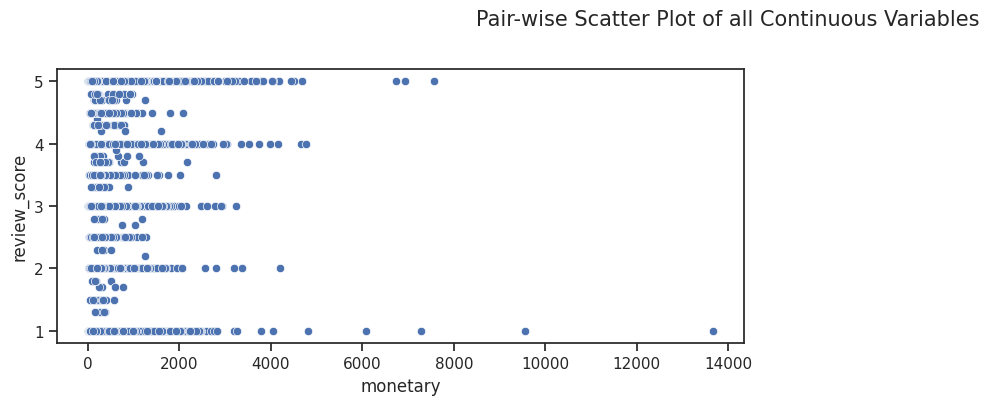

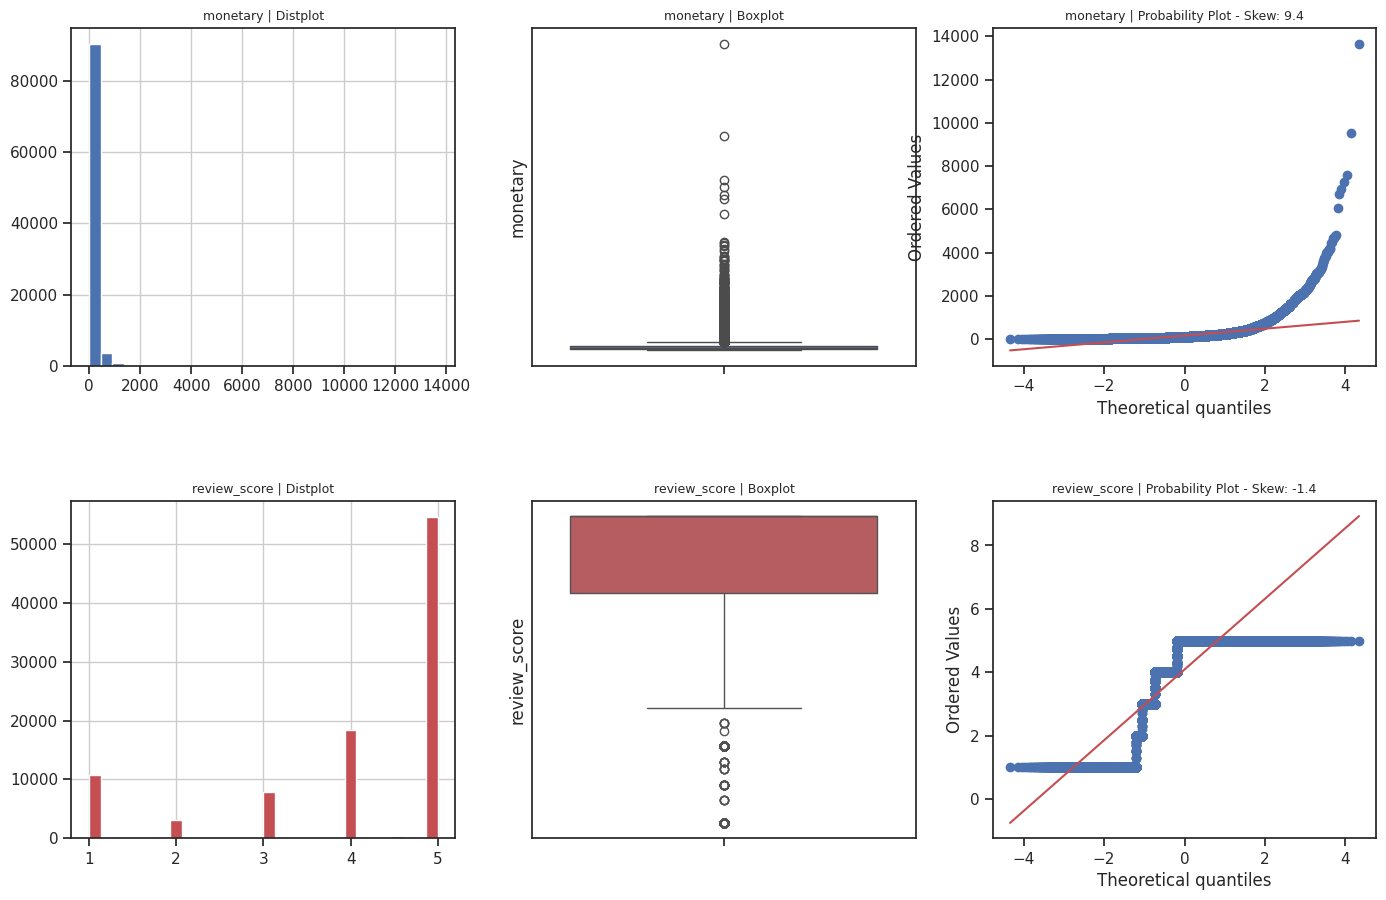

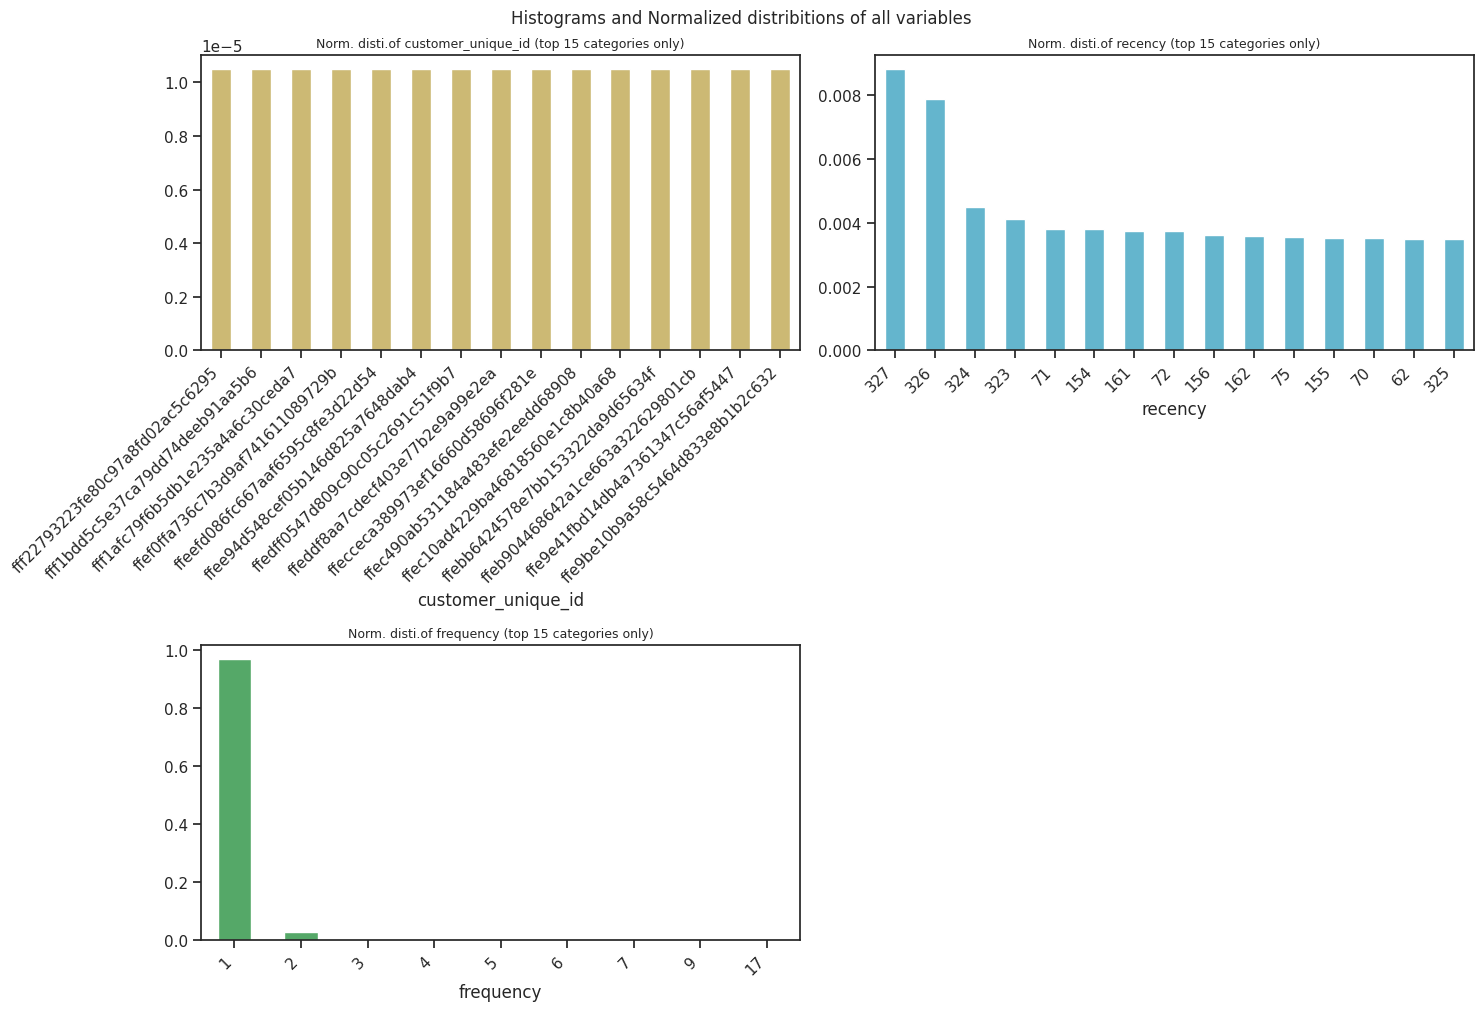

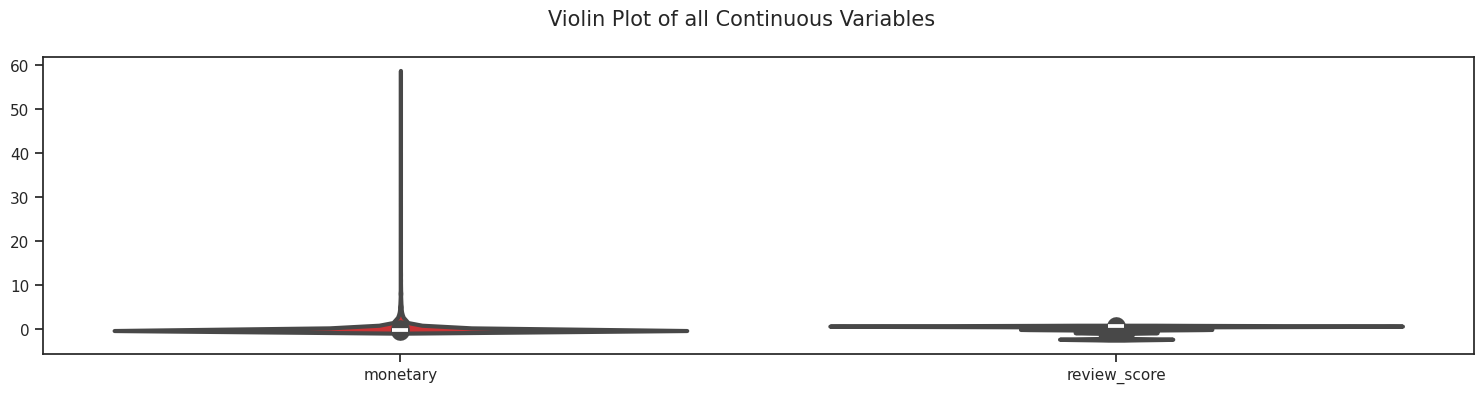

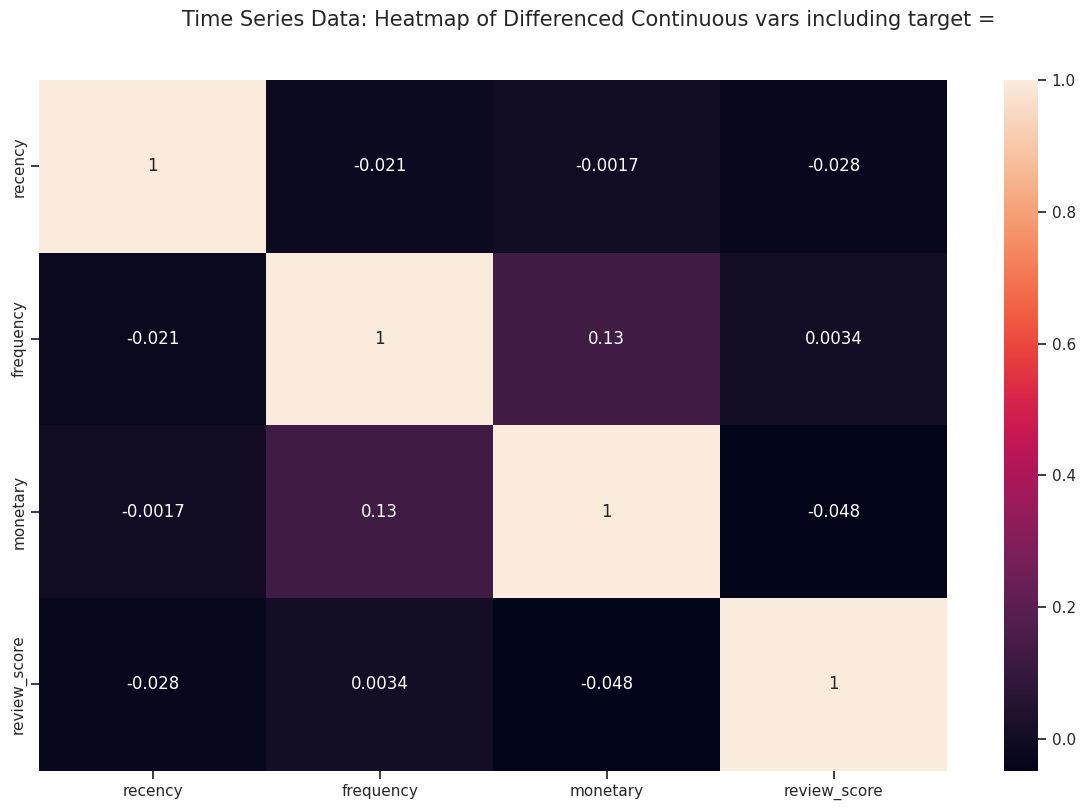

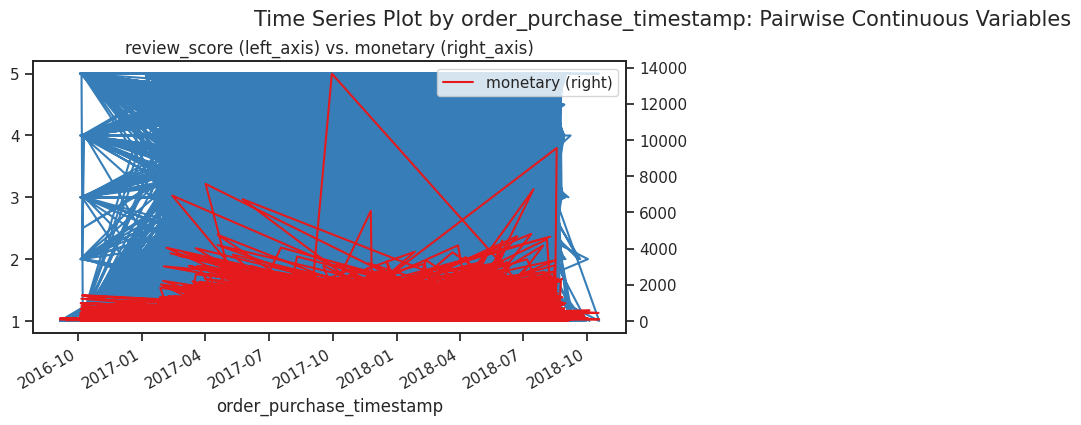

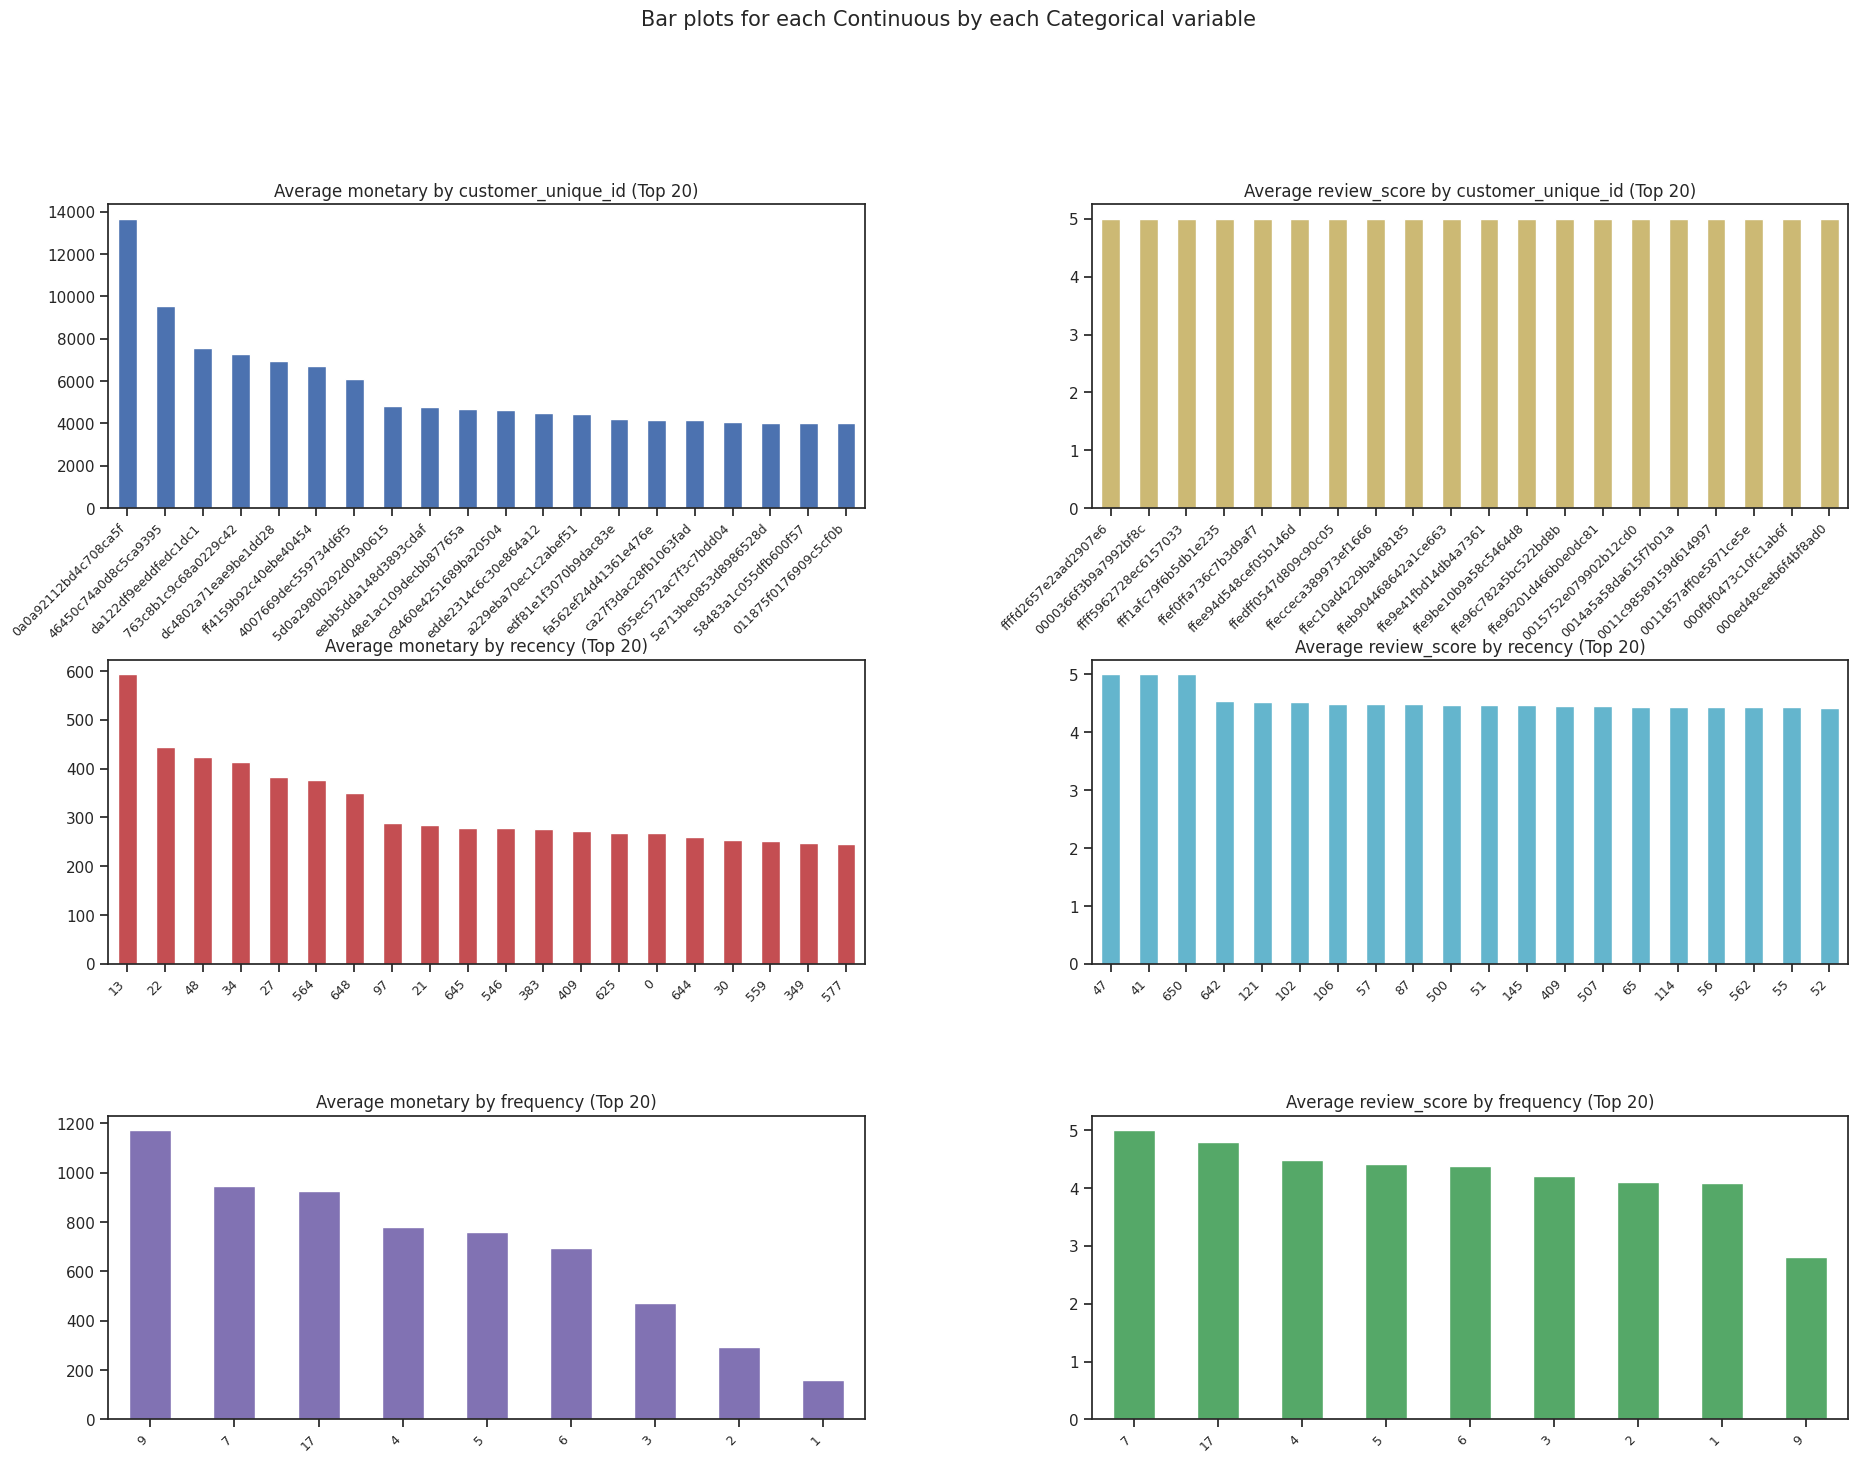

All Plots done
Time to run AutoViz = 19 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [ ]:
from autoviz import AutoViz_Class
AV = AutoViz_Class()

%matplotlib inline
dfte = AV.AutoViz(rfms, sep=',', depVar='', dfte=None, header=0, verbose=1,
                    lowess=False, chart_format='svg',max_rows_analyzed=150000,
                    max_cols_analyzed=30, save_plot_dir=None)

Globalement il existe des valeurs extrêmes au sein de  chaque variable (des outliers) et aussi un écart considérable entre les données des différentes variables, ce qui conduirait à un écrasement des valeurs poids des variables de faibles valeurs par les variables à valeurs fortes. => Ainsi une normalisation ou standardisation s'impose.

Il n'existe:
- quasiment pas de relation linéaire (quasiment pas de corrélation entre les variables rfms)
- une asymétrie pour les variables aléatoires continues :
    - asymétrie à gauche pour review_score ( Une bonne majorité de notes élevées)
    - asymétrie à droite pour monetary (On note tout de même quelques clients très dépensiers)


**Données et variables pour le clustering**


In [ ]:
rfms_clustering_data = rfms[['customer_unique_id', 'recency', 'frequency', 'monetary',
       'review_score',]]

rfms_clustering_data

,customer_unique_id,recency,frequency,monetary,review_score
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0
...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0


## **Séparation temporelle des données**

Stratégie :

| Set       | Années          | Rôle                           |
| --------- | --------------- | ------------------------------ |
| **Train** | 2016–2017       | Former le modèle de clustering |
| **Test**  | Janv → Déc 2018 | Évaluer la stabilité du modèle |


In [28]:
train = rfms[rfms['order_purchase_timestamp'] < "2018-01-01"]
train = train[['recency', 'frequency', 'monetary', 'review_score']] # sélection variables pour la clusterisation
test  = rfms[rfms['order_purchase_timestamp'] >= "2018-01-01"]
test = test[['recency', 'frequency', 'monetary', 'review_score']]


In [29]:
print("La taille du jeu de train est : ", train.shape)
print("La taille du jeu de test est : ", test.shape)


La taille du jeu de train est :  (42980, 4)
La taille du jeu de test est :  (52400, 4)


In [31]:
rfms[['recency','frequency','monetary','review_score']].skew()

recency          0.446016
frequency       11.844678
monetary         9.377622
review_score    -1.361734
dtype: float64

## **Etude de la distribution concrète des variables**

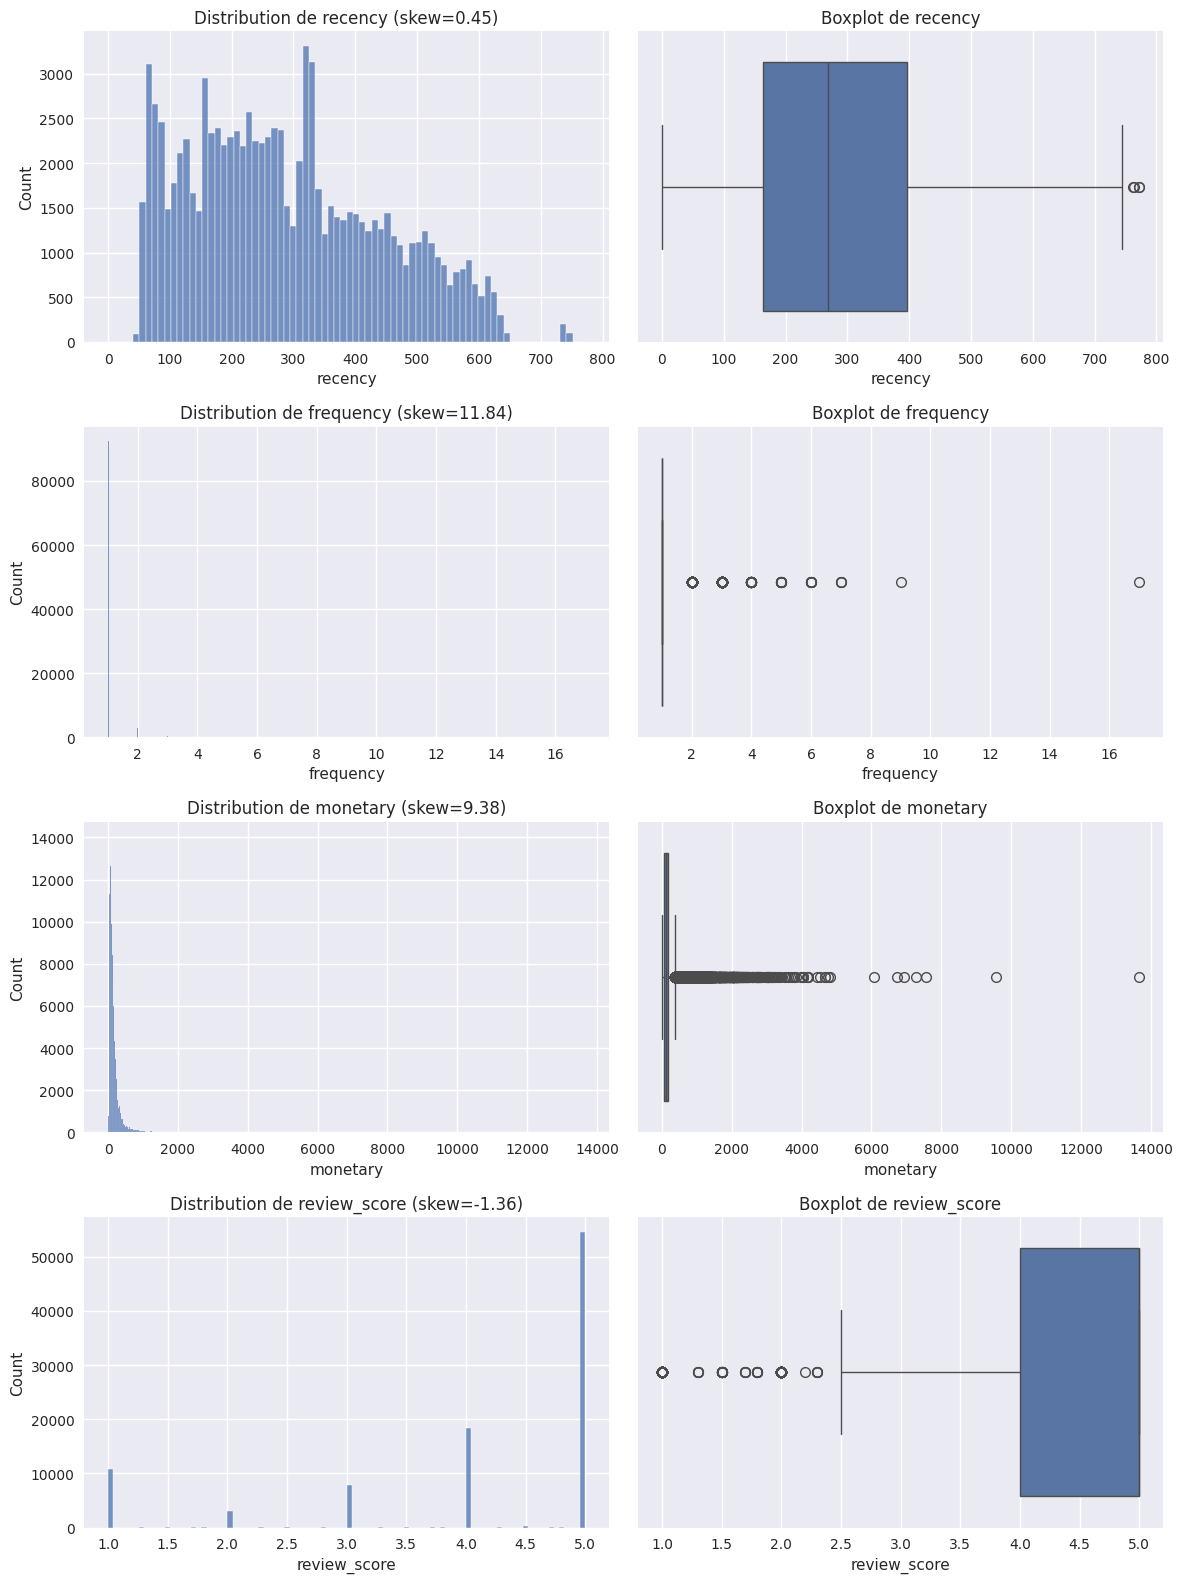

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

vars_to_plot = ["recency", "frequency", "monetary", "review_score"]

plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(len(vars_to_plot), 2, figsize=(12, 4 * len(vars_to_plot)))

for i, var in enumerate(vars_to_plot):
    # -------------------
    # Histogramme
    # -------------------
    sns.histplot(rfms[var], kde=False, ax=axes[i, 0])
    skew_value = rfms[var].skew()
    axes[i, 0].set_title(f"Distribution de {var} (skew={skew_value:.2f})")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Count")

    # -------------------
    # Boxplot pour visualiser l'asymétrie / outliers
    # -------------------
    sns.boxplot(x=rfms[var], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot de {var}")

plt.tight_layout()
plt.show()


On voit très clairement les asymétries (``frequency (très forte), review_score, monetary``) 
et la forme presque symétrique de la variable ``recency``.

***Actions de transformations compte tenu des asymétries***:
    
| Variable         | Type              | Skew  | Transformation ?        | Pourquoi                |
| ---------------- | ----------------- | ----- | ----------------------- | ----------------------- |
| **recency**      | continue positive | 0.4   | ❌ Non                  | asymétrie faible        |
| **frequency**    | discrète positive | 12    | ✔️ log1p ou Yeo-Johnson (généralisation de log1p) | long-tail brutale       |
| **monetary**     | positive          | 9     | ✔️ log1p ou Yeo-Johnson | distribution Pareto     |
| **review_score** | bornée 1-5        | -1.36 | ❌ Non                  | log aggraverait la skew |


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

numerical_skewed = ["frequency", "monetary"]
numerical_normal = ["recency", "review_score"]

def kmeans_model(k: int) -> KMeans:
    """build kmeans model"""
    return KMeans(n_clusters=k, init="k-means++", random_state=42)


# création de notre transformer spécifique à nos données
preprocessor = ColumnTransformer(                         # liste les différentes transformations à appliquer
    transformers=[
        ('skewed', Pipeline(steps=[
            ('yeo', PowerTransformer(method="yeo-johnson")),
            ('scaler', RobustScaler())
        ]), numerical_skewed),
        ('scaler', RobustScaler(), numerical_normal)
    ]
)
